# Data Wrangling

## Table of Contents

* [Data Description](#data-desc)
* [Data Cleaning](#data-cleaning)

In [1]:
import csv
import folium
import json
from IPython.display import IFrame, display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sn

from statsplotter import q_q_plot

<a id="data-desc"></a>

***

## Data Description

I am using data from the Cook County Government Open Data Portal. Specifically, I grabbed the dataset "Archive - Cook County Assessor's Residential Sales Data" which can be found at this link: https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Residential-Sales-Data/5pge-nu6u The description of the dataset on the site reads:

>This is the data set of residential sales used by the Cook County Assessor in their Computer Assisted Mass Appraisal system used to assess residential property values. This data set contains property information for every arm's-length residential sale in Cook County where class is within a specified list of classes. For disclaimers, see data set narrative at https://datacatalog.cookcountyil.gov/stories/s/p2kt-hk36

>This data set was replaced by the more comprehensive data set Cook County Assessor's Sales.

The "more comprehensive data set" can be found at this link: https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Sales/93st-4bxh While it has many more records (1.95M compared to 583K), the new dataset only have 11 columns of attributes compared to the 83 in our dataset. Because this dataset is so much richer than the "more comprehensive" one, I have decided to use it over the larger and more recently updated one. To see how this data is used, I recommend checking out the Cook County Assessors Office Gitlab page to see their code (mostly in R): https://gitlab.com/ccao-data-science---modeling

<a id="data-cleaning"></a>

***

## Data Cleaning

The data was downloaded to `./data` and we will use the next cell to do a bit of cleaning. First, we load the CSV using pandas and then keep only the rows with "Pure Market Filter" equal to 1 because these are sales that reflect the market. Sales with "Pure Market Filter" equal to 0 means they were not traditional sales with a market price, an example may be a sale within a family, thus using them in our model would introduce error since our objective is to determine the market price of houses. There are also some data entry errors forcing me to filter out any row with a sales price of zero dollars or lower. Lastly, we have a list of 60 columns which we may use for our model, the columns are listed in the variable `drop_if_no_data`. These columns were chosen based on looking at the description of the column on the Open Data Portal and consulting the literature. We drop rows if any of the columns has missing data. The result brings us from 583K rows in the initial dataset to 326,484 rows.

In [2]:
# Data from: https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Residential-Sales-Data/5pge-nu6u
chicago_sales = pd.read_csv("./data/Cook_County_Assessors_Residential_Sales_Data_2020.csv")
chicago_sales = chicago_sales[chicago_sales["Pure Market Filter"] == 1]
chicago_sales = chicago_sales[chicago_sales["Sale Price"] > 0]
drop_if_no_data = [
    'Age',
    'Age Decade',
    'Age Decade Squared', 
    'Age Squared',
    'Apartments',
    'Attic Finish', 
    'Attic Type', 
    'Basement', 
    'Basement Finish',
    'Bedrooms',  
    'Building Square Feet', 
    'Cathedral Ceiling',
    'Census Tract', 
    'Central Air',
    'Central Heating',
    'Deed No.',
    'Design Plan',
    'Estimate (Building)', 
    'Estimate (Land)', 
    'Fireplaces', 
    'Floodplain',
    'Full Baths',
    'Garage 1 Area',
    'Garage 1 Attachment',
    'Garage 1 Material',
    'Garage 1 Size', 
    'Garage 2 Area', 
    'Garage 2 Attachment', 
    'Garage 2 Material',
    'Garage 2 Size', 
    'Garage Indicator',
    'Half Baths', 
    'Land Square Feet',
    'Latitude', 
    'Longitude',
    'Lot Size Squared',
    'Multi Property Indicator',
    'Neighborhood Code',
    "O'Hare Noise",
    'PIN',
    'Porch',
    'Property Class',
    'Pure Market Filter',
    'Road Proximity',
    'Roof Material',
    'Rooms',
    'Sale Date',
    'Sale Half of Year',
    'Sale Half-Year',
    'Sale Price',
    'Sale Quarter',
    'Sale Quarter of Year',
    'Sale Year',
    'Site Desirability',
    'Square root of lot size',
    'Town Code',
    'Town and Neighborhood',
    'Type of Residence',
    'Use',
    'Wall Material'
]
chicago_sales = chicago_sales.dropna(subset=drop_if_no_data, axis=0)

print("Data frame has {} rows and {} columns".format(len(chicago_sales), len(chicago_sales.columns)))
left = set(list(chicago_sales.columns))-set(drop_if_no_data)
left = list(left)
left.sort()
print("Here is a list of rows you did not list in drop_if_no_data: ", left)
chicago_sales.head()

Data frame has 326484 rows and 83 columns
Here is a list of rows you did not list in drop_if_no_data:  ['Condition, Desirability and Utility', 'Condo Class Factor', 'Condo Strata', 'Construction Quality', 'Improvement Size Squared', 'Large Lot', 'Modeling Group', 'Most Recent Sale', 'Multi Code', 'Multi-Family Indicator', 'Neigborhood Code (mapping)', 'Number of Commercial Units', 'Number of Units', 'Other Heating', 'Other Improvements', 'Percent Ownership', 'Property Address', 'Renovation', 'Repair Condition', 'Sale Month of Year', 'Square root of age', 'Square root of improvement size', 'Total Building Square Feet']


,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,...,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood
2,16094150130000,211,13,4500.0,77,3.0,6.0,2.0,2.0,24.0,...,75.69,2.025000e+07,55279225.0,1,1.0,13,67.082039,9.327379,86.226446,7713
5,4252000820000,204,100,33898.0,25,5.0,0.0,2.0,4.0,11.0,...,37.21,1.149074e+09,22014864.0,1,1.0,100,184.114095,7.810250,68.498175,25100
8,14322110150000,208,12,3720.0,74,3.0,0.0,2.0,6.0,9.0,...,0.16,1.383840e+07,18378369.0,1,1.0,12,60.991803,2.000000,65.475186,7412
9,27021200080000,204,34,16079.0,28,1.0,0.0,3.0,1.0,7.0,...,8.41,2.585342e+08,4875264.0,1,1.0,34,126.802997,5.385165,46.989360,2834
11,13121080620000,204,42,7560.0,71,1.0,0.0,2.0,1.0,6.0,...,38.44,5.715360e+07,6441444.0,1,1.0,42,86.948260,7.874008,50.378567,7142


Next, I dropped a considerable number of rows, in many cases based on the description on the Open Data site. Often the column was dropped because it was a duplicate of other data or only relevant to a slice of the data (i.e. "Total Building Square Feet" only applies to multi-unit residences). There are also many rows with names that look like they would be extremely useful like "Condition, Desirability and Utility" or "Construction Quality", but notes in the column descriptions recommend against using them, saying things like "In general, this column is not useful for analytical purposes." Dropping the columns brings us down to a total of 60 columns.

In [3]:
cols_to_drop = [
    'Condition, Desirability and Utility', 
    'Condo Class Factor', 
    'Condo Strata', 
    'Construction Quality', 
    'Improvement Size Squared', 
    'Large Lot', 
    'Modeling Group', 
    'Most Recent Sale', 
    'Multi Code', 
    'Multi-Family Indicator', 
    'Neigborhood Code (mapping)', 
    'Number of Commercial Units', 
    'Number of Units', 
    'Other Heating', 
    'Other Improvements', 
    'Percent Ownership', 
    'Property Address', 
    'Renovation', 
    'Repair Condition', 
    'Sale Month of Year', 
    'Square root of age', 
    'Square root of improvement size',
    'Total Building Square Feet',
]
chicago_sales = chicago_sales.drop(cols_to_drop, axis = 1)
print("Data frame has {} rows and {} columns".format(len(chicago_sales), len(chicago_sales.columns)))

Data frame has 326484 rows and 60 columns


Here we use the pandas `describe` function to get an idea of the distribution of the data:

In [4]:
chicago_sales.describe()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,...,Sale Quarter of Year,Sale Half of Year,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Pure Market Filter,Garage Indicator,Square root of lot size,Town and Neighborhood
count,3.264840e+05,326484.000000,326484.000000,3.264840e+05,326484.000000,326484.000000,326484.000000,326484.000000,326484.000000,326484.000000,...,326484.000000,326484.000000,326484.000000,326484.000000,326484.000000,3.264840e+05,326484.0,326484.000000,326484.000000,326484.000000
mean,1.650814e+13,220.004202,108.797384,7.005194e+03,44.663628,2.117905,0.387976,1.947195,1.167034,7.066548,...,2.562708,1.530050,5337.762788,6.580141,53.377628,2.126040e+08,1.0,0.837490,77.876430,23592.684190
std,8.068166e+12,29.478777,100.022183,1.278795e+04,23.764622,1.281430,1.042638,0.782430,0.611666,3.326263,...,1.065477,0.499097,4487.626551,3.174807,44.876266,2.077391e+10,0.0,0.368919,30.666894,28115.681293
min,1.011000e+12,202.000000,10.000000,1.490000e+02,10.000000,1.000000,-5.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,0.100000,0.010000,2.220100e+04,1.0,0.000000,12.206556,1011.000000
25%,1.036107e+13,203.000000,34.000000,3.720000e+03,24.000000,1.000000,0.000000,1.000000,1.000000,5.000000,...,2.000000,1.000000,2209.000000,4.700000,22.090000,1.383840e+07,1.0,1.000000,60.991803,2911.000000
50%,1.608319e+13,205.000000,80.000000,5.125000e+03,37.000000,2.000000,0.000000,2.000000,1.000000,6.000000,...,3.000000,2.000000,3721.000000,6.100000,37.210000,2.626562e+07,1.0,1.000000,71.589105,7240.000000
75%,2.310200e+13,211.000000,150.000000,8.000000e+03,71.000000,2.000000,0.000000,2.000000,1.000000,8.000000,...,3.000000,2.000000,8281.000000,9.100000,82.810000,6.400000e+07,1.0,1.000000,89.442719,37185.000000
max,3.332302e+13,295.000000,600.000000,2.980767e+06,77.000000,8.000000,6.000000,4.000000,6.000000,241.000000,...,4.000000,2.000000,32761.000000,18.100000,327.610000,8.884972e+12,1.0,1.000000,1726.489791,77170.000000


One of my first questions about the data was "What does the spatial distribution of our data look like?" Below you can see a choropleth map of the number of sales per census tract. This was created with a census tract GeoJSON from the Census Bureau. The color indicates the number of housing sales within the census tract (see the legend in the top-right). The data seems fairly evenly distributed across Chicago, but there is a distinct lake of data downtown. I would assume this is due to zoning laws not allowing for residential buildings there.

In [5]:
chicago_sales["Census Tract"] = chicago_sales["Census Tract"].astype(int)
tract_counts = chicago_sales["Census Tract"].value_counts()
tract_counts = tract_counts.to_frame()
tract_counts["count"] = tract_counts["Census Tract"]
tract_counts["Census Tract"] = tract_counts.index.astype(str)

m = folium.Map(zoom_start=10, location=[41.88, -87.6])
geo_path = "./data/geodata/Illinois_CensusTract.geojson"

folium.Choropleth(
 geo_data=geo_path,
 data=tract_counts,
 columns=['Census Tract', "count"],
 key_on='feature.properties.TRACTCE',
 nan_fill_color='grey',
 nan_fill_opacity=0.1,
 fill_color='BuPu',
 fill_opacity=0.85,
 line_opacity=0.5,
 legend_name="Housing Sales per Census Tract"
).add_to(m)
m.save('./maps/ChicagoSales.html')


IFrame(src='./maps/ChicagoSales.html', width=900, height=1000)

Similarly, I was curious about the temporal distribution of the data. Using the "Sale Date" column, I created a histogram of the number of sales which can be seen below. The data runs from the beginning of 2013 to the end of 2019 with peaks in the summer.

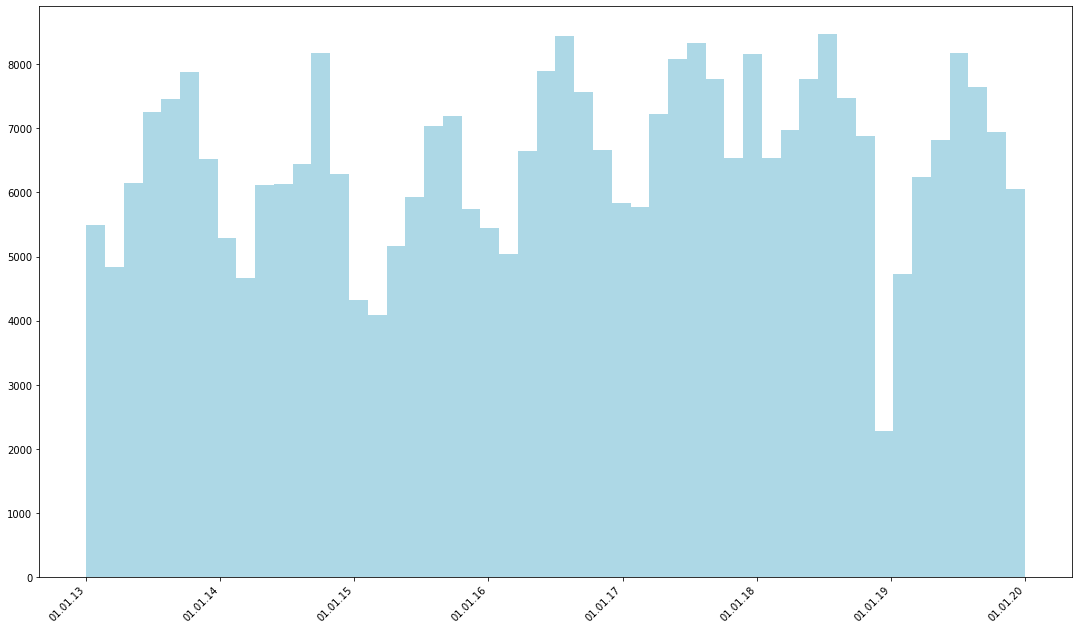

In [6]:
chicago_sales['Sale Date'] = pd.to_datetime(chicago_sales['Sale Date'], format='%m/%d/%Y')
chicago_sales["Sale Date"] = chicago_sales["Sale Date"].astype("datetime64")

fig, ax = plt.subplots(1,1)
ax.hist(chicago_sales["Sale Date"], bins=50, color='lightblue')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
plt.xticks(rotation=45, ha="right")
fig.set_size_inches(18.5, 10.5)
plt.show()

In [7]:
# Categorical --> Boolean (excluding already boolean)
print(sorted(list(chicago_sales.columns)))
categorical = [
    "Attic Finish",
    "Attic Type",
    "Basement",
    "Basement Finish",
    "Cathedral Ceiling",
    #"Census Tract",
    "Central Heating",
    "Design Plan",
    "Fireplaces",
    'Garage 1 Material',
    'Garage 2 Material',
    #"Neighborhood Code",
    "Porch",
    "Property Class",
    "Roof Material",
    'Site Desirability',
    #"Town Code",
    #'Town and Neighborhood',
    "Type of Residence",
    "Wall Material",
]
for col in chicago_sales[categorical]:
    print(col, len(chicago_sales[col].unique()))
    for val in chicago_sales[col].unique():
        print("Bool-{}-{}".format(col, int(val)))
        chicago_sales["Bool-{}-{}".format(col, int(val))] = np.where(chicago_sales[col] == val, 1, 0)
chicago_sales.head()

['Age', 'Age Decade', 'Age Decade Squared', 'Age Squared', 'Apartments', 'Attic Finish', 'Attic Type', 'Basement', 'Basement Finish', 'Bedrooms', 'Building Square Feet', 'Cathedral Ceiling', 'Census Tract', 'Central Air', 'Central Heating', 'Deed No.', 'Design Plan', 'Estimate (Building)', 'Estimate (Land)', 'Fireplaces', 'Floodplain', 'Full Baths', 'Garage 1 Area', 'Garage 1 Attachment', 'Garage 1 Material', 'Garage 1 Size', 'Garage 2 Area', 'Garage 2 Attachment', 'Garage 2 Material', 'Garage 2 Size', 'Garage Indicator', 'Half Baths', 'Land Square Feet', 'Latitude', 'Longitude', 'Lot Size Squared', 'Multi Property Indicator', 'Neighborhood Code', "O'Hare Noise", 'PIN', 'Porch', 'Property Class', 'Pure Market Filter', 'Road Proximity', 'Roof Material', 'Rooms', 'Sale Date', 'Sale Half of Year', 'Sale Half-Year', 'Sale Price', 'Sale Quarter', 'Sale Quarter of Year', 'Sale Year', 'Site Desirability', 'Square root of lot size', 'Town Code', 'Town and Neighborhood', 'Type of Residence', 'U

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,...,Bool-Type of Residence-1,Bool-Type of Residence-2,Bool-Type of Residence-4,Bool-Type of Residence-8,Bool-Type of Residence-7,Bool-Type of Residence-6,Bool-Wall Material-2,Bool-Wall Material-3,Bool-Wall Material-1,Bool-Wall Material-4
2,16094150130000,211,13,4500.0,77,3.0,6.0,2.0,2.0,24.0,...,0,0,0,0,0,0,1,0,0,0
5,4252000820000,204,100,33898.0,25,5.0,0.0,2.0,4.0,11.0,...,0,0,0,0,0,0,1,0,0,0
8,14322110150000,208,12,3720.0,74,3.0,0.0,2.0,6.0,9.0,...,0,0,0,0,0,0,1,0,0,0
9,27021200080000,204,34,16079.0,28,1.0,0.0,3.0,1.0,7.0,...,1,0,0,0,0,0,0,1,0,0
11,13121080620000,204,42,7560.0,71,1.0,0.0,2.0,1.0,6.0,...,1,0,0,0,0,0,1,0,0,0


In [8]:
cols_of_interest = [ 
    'Age',
    'Age Decade',
    'Bedrooms',  
    'Building Square Feet', 
    'Estimate (Building)', 
    'Estimate (Land)', 
    'Fireplaces', 
    'Full Baths',
    'Garage 1 Area',
    'Garage 2 Area', 
    'Half Baths', 
    'Land Square Feet',
    'Lot Size Squared',
    'Rooms',
    'Sale Price',
    ]
# Remove erroneous negative values
for col in cols_of_interest:
    chicago_sales[col] = chicago_sales[col].abs()

In [16]:
# Transform data to look normal
from scipy.stats import boxcox
#new_data = boxcox(chicago_sales["Bedrooms"])
tdata = chicago_sales.copy()
tdata["Building Square Feet"] =  np.log(tdata["Building Square Feet"])
tdata["Land Square Feet"] = np.log(tdata["Land Square Feet"])
tdata["Rooms"] = np.log(tdata["Rooms"])
tdata["Sale Price"] = np.log(tdata["Sale Price"])
#plt.hist(new_data)
#plt.show()

In [10]:
# Normality Checks:
column_dropdown = widgets.Dropdown(
    options=cols_of_interest,
    value="Sale Price",
    description="Column: "
)
display(column_dropdown)

Dropdown(description='Column: ', index=14, options=('Age', 'Age Decade', 'Bedrooms', 'Building Square Feet', '…

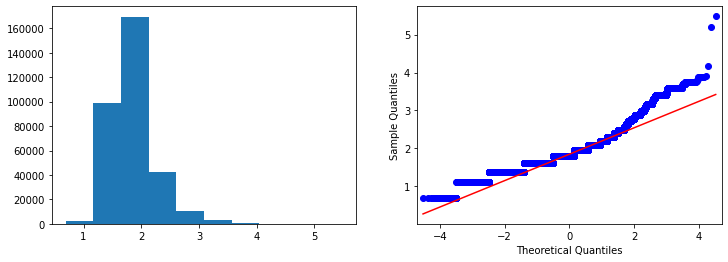

In [17]:
q_q_plot(tdata[column_dropdown.value])

In [13]:
# normalize values
normalized_df = chicago_sales.copy()
normalized_df[cols_of_interest] = (chicago_sales[cols_of_interest] - chicago_sales[cols_of_interest].mean(axis=0)) / chicago_sales[cols_of_interest].std(axis=0)

In [14]:
corr_df = normalized_df[cols_of_interest]
corr_df.describe()

,Age,Age Decade,Bedrooms,Building Square Feet,Estimate (Building),Estimate (Land),Fireplaces,Full Baths,Garage 1 Area,Garage 2 Area,Half Baths,Land Square Feet,Lot Size Squared,Rooms,Sale Price
count,3.264840e+05,3.264840e+05,3.264840e+05,3.264840e+05,3.264840e+05,3.264840e+05,3.264840e+05,3.264840e+05,3.264840e+05,3.264840e+05,3.264840e+05,3.264840e+05,3.264840e+05,3.264840e+05,3.264840e+05
mean,-1.519091e-16,6.243507e-16,-1.434431e-16,-6.833732e-18,6.711857e-17,2.964186e-17,-4.613857e-18,5.562745e-17,4.605152e-17,1.893423e-18,3.638854e-17,5.484396e-18,3.982716e-18,-8.096014e-17,-7.123186e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.041113e+00,-2.041113e+00,-1.673831e+00,-1.360525e+00,-1.108572e+00,-9.326572e-01,-5.807080e-01,-7.494044e-01,-2.102536e+00,-4.180177e-02,-8.122499e-01,-5.361448e-01,-1.023311e-02,-1.523195e+00,-9.102411e-01
25%,-5.922064e-01,-5.922064e-01,-3.542860e-01,-6.496492e-01,-5.498118e-01,-4.416632e-01,-5.807080e-01,-7.494044e-01,-7.755066e-01,-4.180177e-02,-8.122499e-01,-2.568976e-01,-9.568038e-03,-6.212823e-01,-5.441066e-01
50%,-1.512347e-01,-1.512347e-01,-3.542860e-01,-3.207363e-01,-2.493817e-01,-2.423708e-01,-5.807080e-01,-7.494044e-01,5.515224e-01,-4.180177e-02,-8.122499e-01,-1.470285e-01,-8.969825e-03,-3.206446e-01,-2.460122e-01
75%,7.937045e-01,7.937045e-01,3.054867e-01,3.563804e-01,2.001123e-01,8.129376e-02,1.263553e+00,3.454515e-01,5.515224e-01,-4.180177e-02,9.602811e-01,7.779244e-02,-7.153394e-03,2.806307e-01,1.914090e-01
max,3.628522e+00,3.628522e+00,5.704593e+01,1.718591e+01,3.724473e+01,6.803438e+01,3.107814e+00,4.413969e+01,5.515224e-01,2.594127e+01,1.514053e+01,2.325440e+02,4.276883e+02,7.032920e+01,2.951483e+01


In [15]:
corrMatrix = corr_df.corr(method="spearman")
corrMatrix

,Age,Age Decade,Bedrooms,Building Square Feet,Estimate (Building),Estimate (Land),Fireplaces,Full Baths,Garage 1 Area,Garage 2 Area,Half Baths,Land Square Feet,Lot Size Squared,Rooms,Sale Price
Age,1.000000,1.000000,0.091725,-0.074351,-0.122140,0.079119,-0.335121,-0.057879,0.023715,0.005408,-0.395704,-0.315138,-0.315138,0.040919,-0.150898
Age Decade,1.000000,1.000000,0.091725,-0.074351,-0.122140,0.079119,-0.335121,-0.057879,0.023715,0.005408,-0.395704,-0.315138,-0.315138,0.040919,-0.150898
Bedrooms,0.091725,0.091725,1.000000,0.757434,0.407349,0.334521,0.202371,0.663440,-0.055336,0.015582,0.130262,0.122100,0.122100,0.826117,0.331617
Building Square Feet,-0.074351,-0.074351,0.757434,1.000000,0.592044,0.417209,0.386825,0.770506,-0.140018,0.019121,0.265794,0.111079,0.111079,0.824329,0.501747
Estimate (Building),-0.122140,-0.122140,0.407349,0.592044,1.000000,0.637078,0.394827,0.480098,-0.057064,0.007977,0.268488,0.109805,0.109805,0.484338,0.794728
Estimate (Land),0.079119,0.079119,0.334521,0.417209,0.637078,1.000000,0.310018,0.329028,0.035840,0.009689,0.138340,0.315146,0.315146,0.363864,0.680579
Fireplaces,-0.335121,-0.335121,0.202371,0.386825,0.394827,0.310018,1.000000,0.295086,-0.002579,0.008110,0.354031,0.324932,0.324932,0.280887,0.392863
Full Baths,-0.057879,-0.057879,0.663440,0.770506,0.480098,0.329028,0.295086,1.000000,-0.144552,0.019035,0.059060,0.004076,0.004076,0.704443,0.407049
Garage 1 Area,0.023715,0.023715,-0.055336,-0.140018,-0.057064,0.035840,-0.002579,-0.144552,1.000000,0.004451,-0.028725,0.210111,0.210111,-0.087527,-0.017878
Garage 2 Area,0.005408,0.005408,0.015582,0.019121,0.007977,0.009689,0.008110,0.019035,0.004451,1.000000,0.000831,0.009371,0.009371,0.018936,0.006412


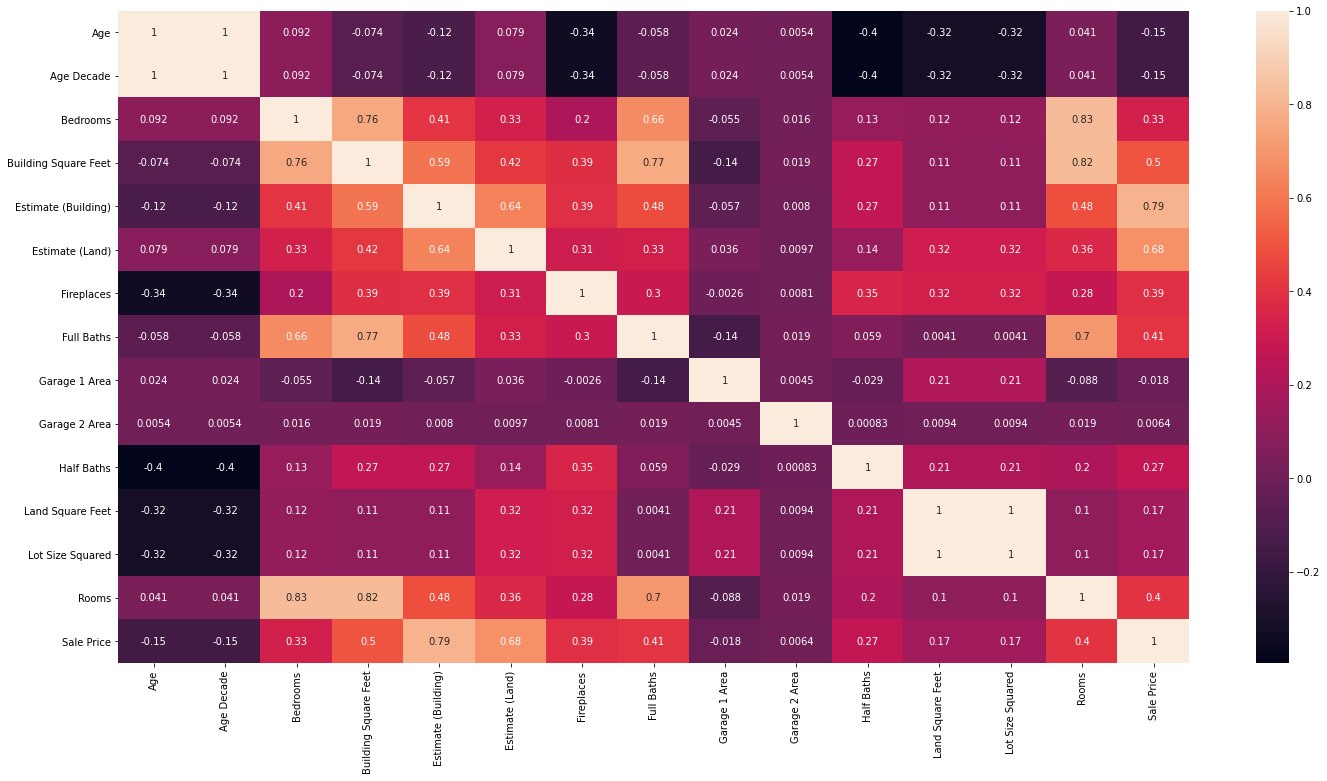

In [16]:
sn.heatmap(corrMatrix, annot=True)
fig = plt.gcf()
fig.set_size_inches(24, 12)
plt.show()

In [ ]:
sn.pairplot(corr_df)
plt.show()

# Data Filtering/Imputing for ML

In [24]:
ml_df = normalized_df
print("Dataframe has {} rows and {} cols".format(len(ml_df), len(ml_df.columns)))

for col in ml_df.columns:
    if col != "PIN":
        if ml_df[col].dtypes == np.int64:
            #print("int64")
            ml_df[col] = ml_df[col].astype("int32")
        elif ml_df[col].dtypes == np.float64:
            ml_df[col] = ml_df[col].astype("float32")
            #print("float64")
        print("Col: {:35s}, Dtype: {}".format(col, ml_df[col].dtypes))
ml_df.to_pickle("./data/processed/Cleaned_Chicago_Sales.pkl")
ml_df.to_csv("./data/processed/Cleaned_Chicago_Sales.csv")

Dataframe has 326484 rows and 133 cols
Col: Property Class                     , Dtype: int32
Col: Neighborhood Code                  , Dtype: int32
Col: Land Square Feet                   , Dtype: float32
Col: Town Code                          , Dtype: int32
Col: Type of Residence                  , Dtype: float32
Col: Apartments                         , Dtype: float32
Col: Wall Material                      , Dtype: float32
Col: Roof Material                      , Dtype: float32
Col: Rooms                              , Dtype: float32
Col: Bedrooms                           , Dtype: float32
Col: Basement                           , Dtype: float32
Col: Basement Finish                    , Dtype: float32
Col: Central Heating                    , Dtype: float32
Col: Central Air                        , Dtype: float32
Col: Fireplaces                         , Dtype: float32
Col: Attic Type                         , Dtype: float32
Col: Attic Finish                       , Dtype: int32


In [ ]:
'''
for val in ml_df["Property Class"].unique():
    df = ml_df[ml_df["Property Class"] == val]
    print("Property Class {} has {} entries".format(val, len(df)) )
    df.to_pickle("./data/processed/Cleaned_Chicago_Sales_PC{}.pkl".format(int(val)))
    df.to_csv("./data/processed/Cleaned_Chicago_Sales_PC{}.csv".format(int(val)))
'''